In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
import pathlib

data_dir = pathlib.Path('/content/drive/MyDrive/AD-PROJECT/HRCT SCAN')

# Check if the data directory exists
if not data_dir.exists():
  print("Error: Data directory doesn't exist. Please provide the correct path.")
else:
  print("Using your dataset from:", data_dir)

Using your dataset from: /content/drive/MyDrive/AD-PROJECT/HRCT SCAN


/content/drive/MyDrive/AD-PROJECT/HRCT SCAN/CLE/subject50_top .jpg


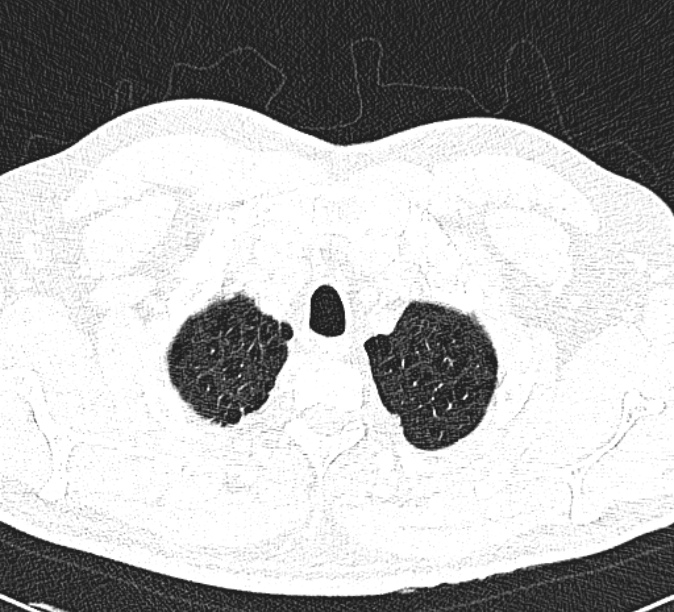

In [ ]:
CLE = list(data_dir.glob('CLE/*'))
print(CLE[0])
PIL.Image.open(str(CLE[0]))

/content/drive/MyDrive/AD-PROJECT/HRCT SCAN/PLE/subject125_top.jpg


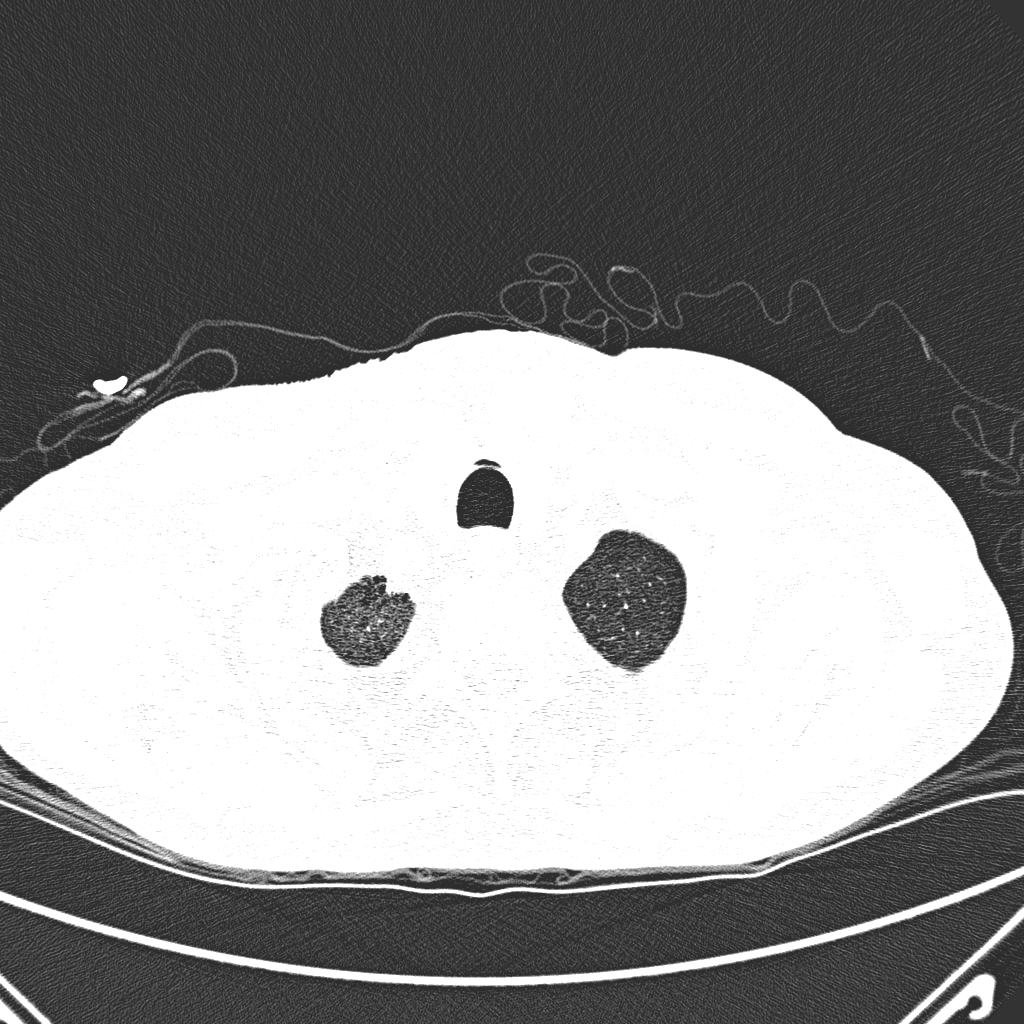

In [ ]:
PLE = list(data_dir.glob('PLE/*'))
print(PLE[1])
PIL.Image.open(str(PLE[1]))

/content/drive/MyDrive/AD-PROJECT/HRCT SCAN/PSE/subject119_bottom.jpg


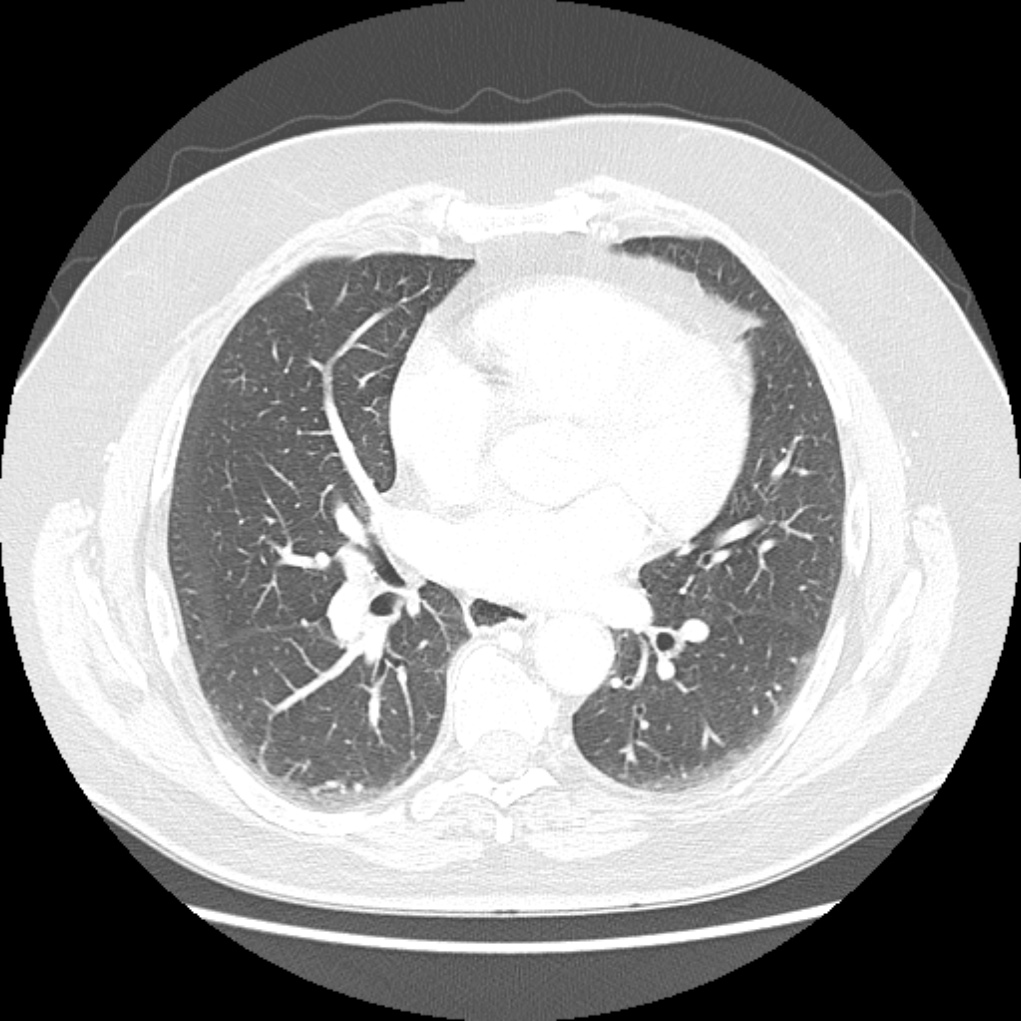

In [ ]:
PSE = list(data_dir.glob('PSE/*'))
print(PSE[3])
PIL.Image.open(str(PSE[3]))

/content/drive/MyDrive/AD-PROJECT/HRCT SCAN/NT/subject40_top.jpg


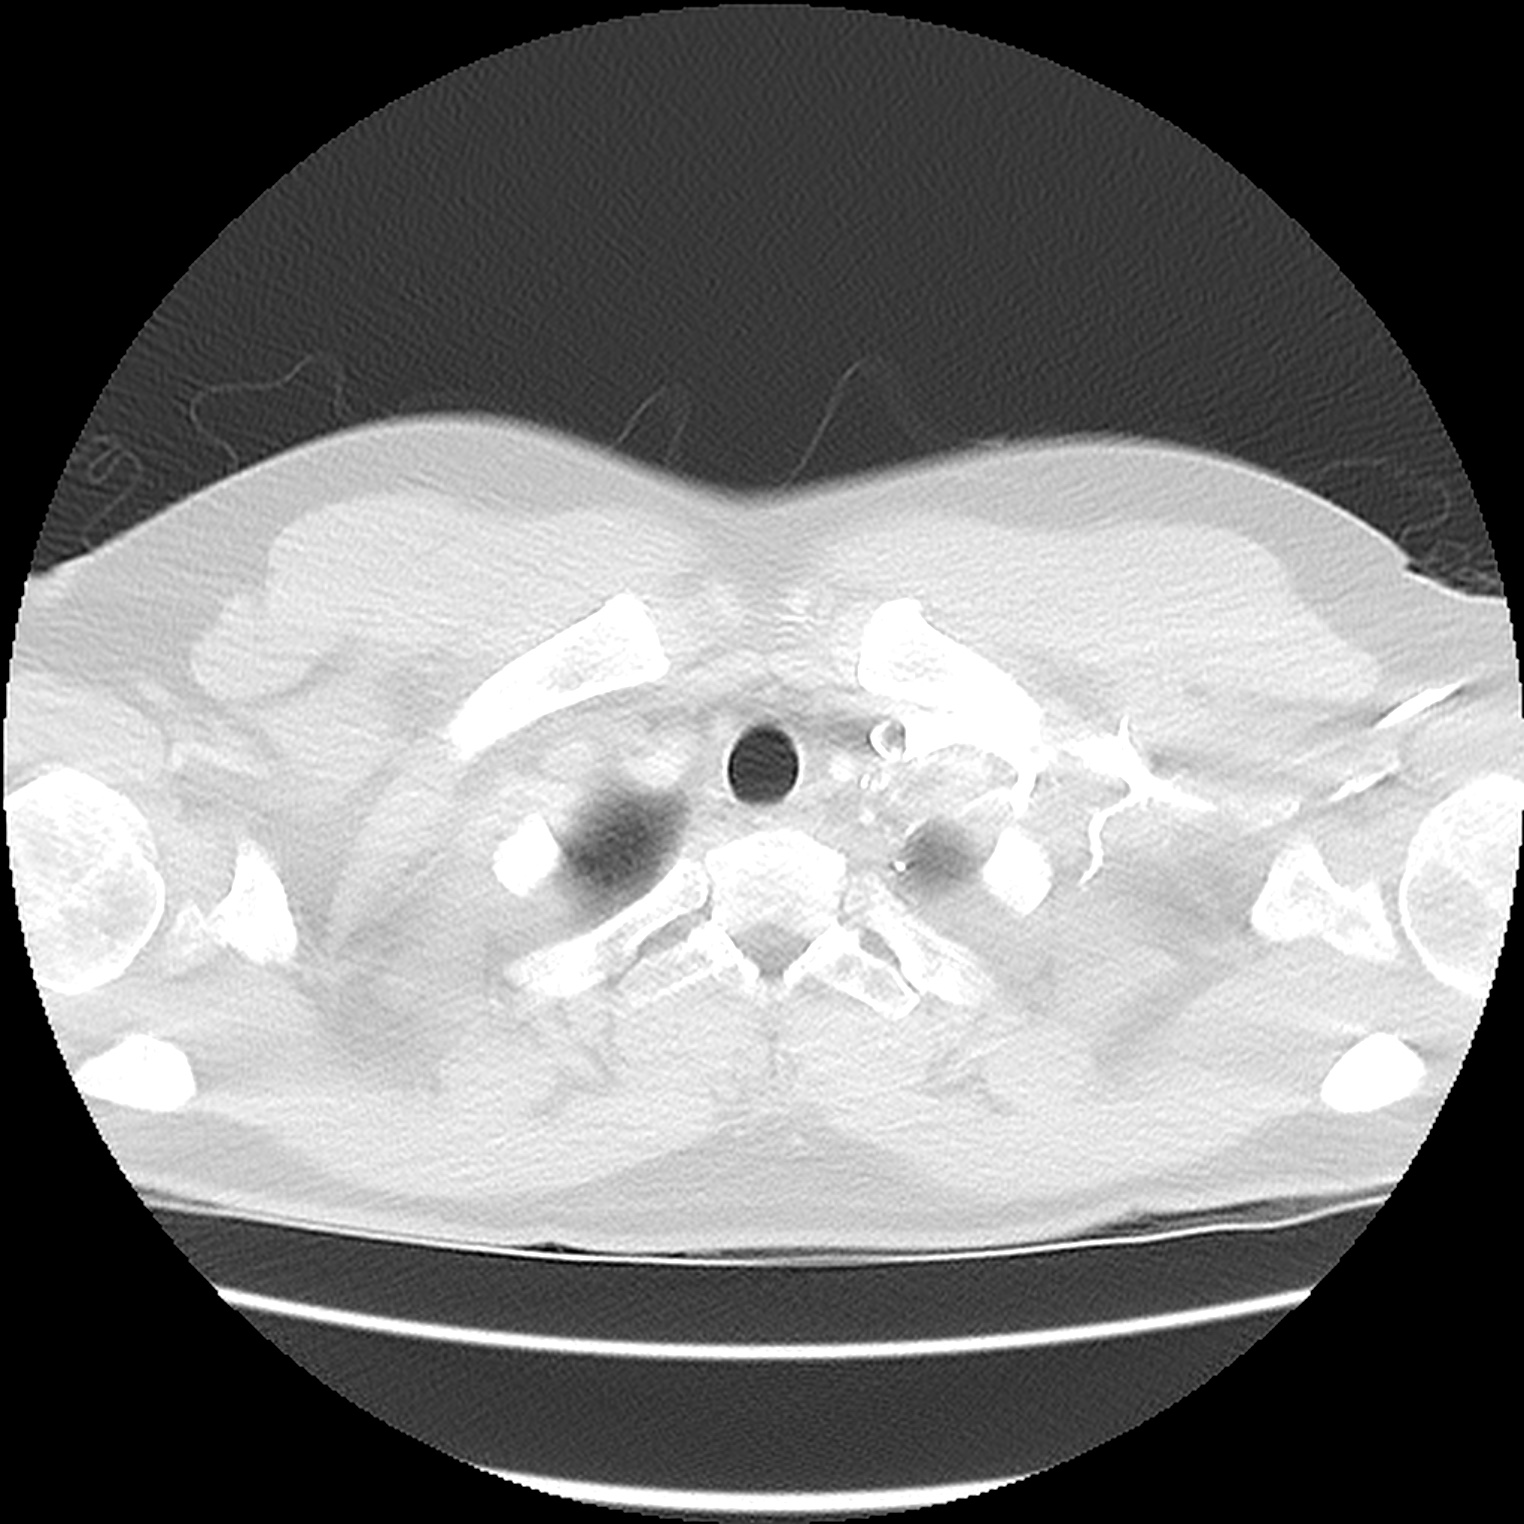

In [ ]:
NT = list(data_dir.glob('NT/*'))
print(NT[0])
PIL.Image.open(str(NT[0]))

In [ ]:
#splitting the dataset
img_height,img_width=224,224
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 447 files belonging to 4 classes.
Using 358 files for training.


In [ ]:
#creating validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 447 files belonging to 4 classes.
Using 89 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['CLE', 'NT', 'PLE', 'PSE']


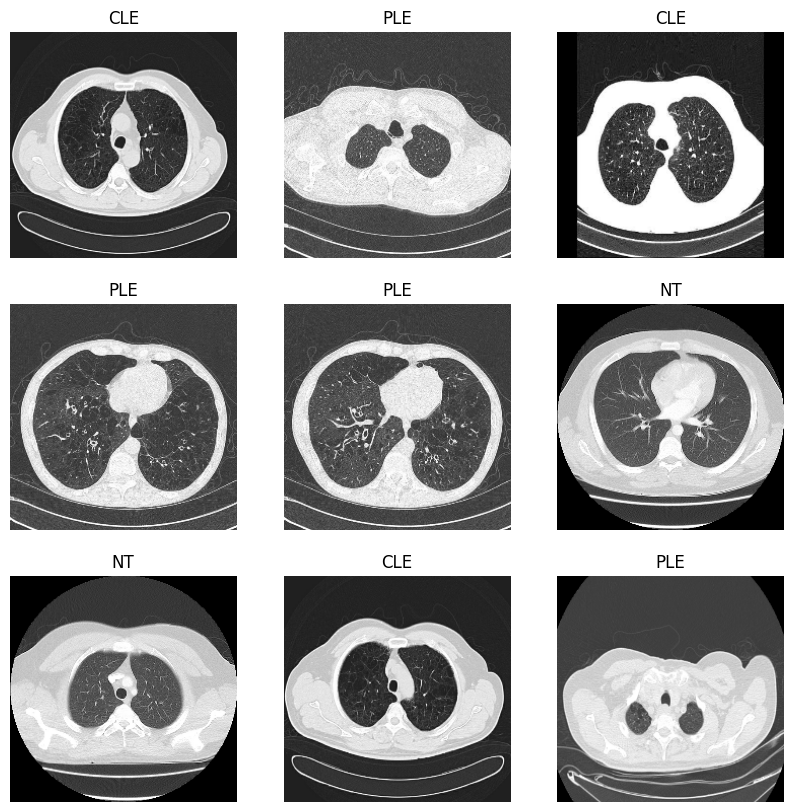

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
import os
from sklearn.model_selection import train_test_split

# Define the path to the main folder containing subfolders for each class
data_dir = '/content/drive/MyDrive/AD-PROJECT/HRCT SCAN'

# Get the list of subfolders (class names)
class_names = os.listdir(data_dir)

# Initialize lists to store file paths and corresponding labels
file_paths = []
labels = []

# Iterate over each class folder
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    # Get the list of file paths in the class folder
    class_files = [os.path.join(class_dir, file_name) for file_name in os.listdir(class_dir)]
    # Add file paths and corresponding labels to the lists
    file_paths.extend(class_files)
    labels.extend([class_name] * len(class_files))

# Split the dataset into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=123)

# Print the number of images in each set for each class
print("Number of images for training:")
for class_name in class_names:
    num_train_images = sum(1 for label in train_labels if label == class_name)
    print(f"{class_name}: {num_train_images}")

print("Number of images for validation:")
for class_name in class_names:
    num_val_images = sum(1 for label in val_labels if label == class_name)
    print(f"{class_name}: {num_val_images}")


Number of images for training:
PSE: 53
NT: 21
PLE: 156
CLE: 127
Number of images for validation:
PSE: 13
NT: 6
PLE: 39
CLE: 32


In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Combine file paths and labels into a dataframe for training set
train_df = pd.DataFrame({'file_paths': train_files, 'labels': train_labels})

# Combine file paths and labels into a dataframe for validation set
val_df = pd.DataFrame({'file_paths': val_files, 'labels': val_labels})

In [ ]:
# Define data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# No data augmentation for validation set
val_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Create data generators for training and validation sets
batch_size = 32  # You can adjust this value based on your preference
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_paths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_paths',
    y_col='labels',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

# Print the number of batches in each set
print("Number of batches in training set:", len(train_generator))
print("Number of batches in validation set:", len(val_generator))

Found 357 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
Number of batches in training set: 12
Number of batches in validation set: 3


In [ ]:
#CNN MODEL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report

# Define the Simple CNN model
simple_cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
simple_cnn_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy', Precision(), Recall()])

# Train the model
history_simple_cnn = simple_cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

# Evaluate the model
val_loss, val_acc, val_precision, val_recall = simple_cnn_model.evaluate(val_generator)
print("Validation Accuracy:", val_acc)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)

# Predict the classes for the validation set
val_pred = simple_cnn_model.predict(val_generator)
val_pred_classes = np.argmax(val_pred, axis=1)
val_true_classes = val_generator.classes

# Print classification report
print("Classification Report:")
print(classification_report(val_true_classes, val_pred_classes, target_names=class_names))


Epoch 1/10
12/12 [==============================] - 75s 6s/step - loss: 1.4726 - accuracy: 0.5322 - precision: 0.6341 - recall: 0.2913 - val_loss: 1.1029 - val_accuracy: 0.5556 - val_precision: 0.5283 - val_recall: 0.3111
Epoch 2/10
12/12 [==============================] - 54s 4s/step - loss: 0.7418 - accuracy: 0.7255 - precision: 0.7755 - recall: 0.6387 - val_loss: 0.7318 - val_accuracy: 0.6444 - val_precision: 0.6517 - val_recall: 0.6444
Epoch 3/10
12/12 [==============================] - 56s 4s/step - loss: 0.5161 - accuracy: 0.8207 - precision: 0.8353 - recall: 0.8095 - val_loss: 0.4159 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 4/10
12/12 [==============================] - 57s 5s/step - loss: 0.5530 - accuracy: 0.8011 - precision: 0.8070 - recall: 0.7731 - val_loss: 0.5686 - val_accuracy: 0.7444 - val_precision: 0.7471 - val_recall: 0.7222
Epoch 5/10
12/12 [==============================] - 62s 5s/step - loss: 0.4356 - accuracy: 0.8375 - precision: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Save the Simple CNN model
simple_cnn_model.save('/content/drive/MyDrive/AD-PROJECT/simple_cnn_model')


In [ ]:
from tensorflow.keras.applications import VGG19

# Load the pre-trained VGG19 model without the fully connected layers
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in vgg19_base.layers:
    layer.trainable = False

# Add custom fully connected layers on top
vgg19_model = Sequential([
    vgg19_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
vgg19_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy', Precision(), Recall()])

# Train the model
history_vgg19 = vgg19_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)
# Evaluate the model
val_loss_vgg19, val_acc_vgg19, val_precision_vgg19, val_recall_vgg19 = vgg19_model.evaluate(val_generator)
print("Validation Accuracy (VGG19):", val_acc_vgg19)
print("Validation Precision (VGG19):", val_precision_vgg19)
print("Validation Recall (VGG19):", val_recall_vgg19)

# Predict the classes for the validation set
val_pred_vgg19 = vgg19_model.predict(val_generator)
val_pred_classes_vgg19 = np.argmax(val_pred_vgg19, axis=1)
val_true_classes_vgg19 = val_generator.classes

# Print classification report
print("Classification Report (VGG19):")
print(classification_report(val_true_classes_vgg19, val_pred_classes_vgg19, target_names=class_names))

80134624/80134624 [==============================] - 2s 0us/step
Epoch 1/10
12/12 [==============================] - 381s 31s/step - loss: 3.1096 - accuracy: 0.4622 - precision_1: 0.4985 - recall_1: 0.4538 - val_loss: 1.0550 - val_accuracy: 0.8333 - val_precision_1: 0.8333 - val_recall_1: 0.8333
Epoch 2/10
12/12 [==============================] - 368s 31s/step - loss: 0.6316 - accuracy: 0.8291 - precision_1: 0.8376 - recall_1: 0.8235 - val_loss: 0.3571 - val_accuracy: 0.8667 - val_precision_1: 0.8764 - val_recall_1: 0.8667
Epoch 3/10
12/12 [==============================] - 372s 31s/step - loss: 0.3869 - accuracy: 0.8824 - precision_1: 0.9064 - recall_1: 0.8683 - val_loss: 0.1911 - val_accuracy: 0.9222 - val_precision_1: 0.9222 - val_recall_1: 0.9222
Epoch 4/10
12/12 [==============================] - 368s 31s/step - loss: 0.1582 - accuracy: 0.9384 - precision_1: 0.9433 - recall_1: 0.9328 - val_loss: 0.1549 - val_accuracy: 0.9444 - val_precision_1: 0.9438 - val_recall_1: 0.9333
Epoch 5

In [ ]:
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model without the fully connected layers
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in resnet50_base.layers:
    layer.trainable = False

# Add custom fully connected layers on top
resnet50_model = Sequential([
    resnet50_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
resnet50_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy', Precision(), Recall()])

# Train the model
history_resnet50 = resnet50_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)
# Evaluate the model
val_loss_resnet50, val_acc_resnet50, val_precision_resnet50, val_recall_resnet50 = resnet50_model.evaluate(val_generator)
print("Validation Accuracy (ResNet50):", val_acc_resnet50)
print("Validation Precision (ResNet50):", val_precision_resnet50)
print("Validation Recall (ResNet50):", val_recall_resnet50)

# Predict the classes for the validation set
val_pred_resnet50 = resnet50_model.predict(val_generator)
val_pred_classes_resnet50 = np.argmax(val_pred_resnet50, axis=1)
val_true_classes_resnet50 = val_generator.classes

# Print classification report
print("Classification Report (ResNet50):")
print(classification_report(val_true_classes_resnet50, val_pred_classes_resnet50, target_names=class_names))


94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/10
12/12 [==============================] - 134s 11s/step - loss: 5.6629 - accuracy: 0.4734 - precision_2: 0.5016 - recall_2: 0.4510 - val_loss: 2.5948 - val_accuracy: 0.5000 - val_precision_2: 0.5000 - val_recall_2: 0.5000
Epoch 2/10
12/12 [==============================] - 102s 9s/step - loss: 2.4931 - accuracy: 0.6106 - precision_2: 0.6165 - recall_2: 0.6078 - val_loss: 0.2702 - val_accuracy: 0.9111 - val_precision_2: 0.9101 - val_recall_2: 0.9000
Epoch 3/10
12/12 [==============================] - 106s 9s/step - loss: 0.7840 - accuracy: 0.7451 - precision_2: 0.7605 - recall_2: 0.7115 - val_loss: 0.2023 - val_accuracy: 0.9333 - val_precision_2: 0.9333 - val_recall_2: 0.9333
Epoch 4/10
12/12 [==============================] - 100s 8s/step - loss: 0.5281 - accuracy: 0.8067 - precision_2: 0.8169 - recall_2: 0.7871 - val_loss: 0.2678 - val_accuracy: 0.9000 - val_precision_2: 0.9195 - val_recall_2: 0.8889
Epoch 5/10

In [ ]:
# Define the path to save the model on your Google Drive
resnet50_model.save('/content/drive/My Drive/AD-PROJECT/resnet50_model')

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Load the pre-trained InceptionV3 model without the fully connected layers
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in inceptionv3_base.layers:
    layer.trainable = False

# Add custom fully connected layers on top
inceptionv3_model = Sequential([
    inceptionv3_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
inceptionv3_model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy', Precision(), Recall()])

# Train the model
history_inceptionv3 = inceptionv3_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)
# Evaluate the model
val_loss_inceptionv3, val_acc_inceptionv3, val_precision_inceptionv3, val_recall_inceptionv3 = inceptionv3_model.evaluate(val_generator)
print("Validation Accuracy (InceptionV3):", val_acc_inceptionv3)
print("Validation Precision (InceptionV3):", val_precision_inceptionv3)
print("Validation Recall (InceptionV3):", val_recall_inceptionv3)

# Predict the classes for the validation set
val_pred_inceptionv3 = inceptionv3_model.predict(val_generator)
val_pred_classes_inceptionv3 = np.argmax(val_pred_inceptionv3, axis=1)
val_true_classes_inceptionv3 = val_generator.classes

# Print classification report
print("Classification Report (InceptionV3):")
print(classification_report(val_true_classes_inceptionv3, val_pred_classes_inceptionv3, target_names=class_names))


Epoch 1/10
12/12 [==============================] - 94s 6s/step - loss: 25.0137 - accuracy: 0.4034 - precision_4: 0.4006 - recall_4: 0.3838 - val_loss: 2.0883 - val_accuracy: 0.6444 - val_precision_4: 0.6517 - val_recall_4: 0.6444
Epoch 2/10
12/12 [==============================] - 72s 6s/step - loss: 2.2388 - accuracy: 0.7367 - precision_4: 0.7408 - recall_4: 0.7367 - val_loss: 1.2017 - val_accuracy: 0.8222 - val_precision_4: 0.8222 - val_recall_4: 0.8222
Epoch 3/10
12/12 [==============================] - 64s 5s/step - loss: 0.4865 - accuracy: 0.9020 - precision_4: 0.9042 - recall_4: 0.8992 - val_loss: 0.4644 - val_accuracy: 0.8778 - val_precision_4: 0.8778 - val_recall_4: 0.8778
Epoch 4/10
12/12 [==============================] - 66s 5s/step - loss: 0.2933 - accuracy: 0.8992 - precision_4: 0.9014 - recall_4: 0.8964 - val_loss: 0.3220 - val_accuracy: 0.9000 - val_precision_4: 0.9000 - val_recall_4: 0.9000
Epoch 5/10
12/12 [==============================] - 73s 6s/step - loss: 0.2543 

3/3 [==============================] - 14s 3s/step
Classification Report (InceptionV3):
              precision    recall  f1-score   support

         PSE       0.50      0.50      0.50        32
          NT       0.14      0.17      0.15         6
         PLE       0.51      0.51      0.51        39
         CLE       0.33      0.31      0.32        13

    accuracy                           0.46        90
   macro avg       0.37      0.37      0.37        90
weighted avg       0.46      0.46      0.46        90



In [ ]:
# Define the path to save the model on your Google Drive
inceptionv3_model.save('/content/drive/My Drive/AD-PROJECT/inceptionv3_model')

NameError: name 'inceptionv3_model' is not defined

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Load the pre-trained EfficientNetB0 model without the fully connected layers
efficientnetb0_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in efficientnetb0_base.layers:
    layer.trainable = False

# Add custom fully connected layers on top
efficientnetb0_model = Sequential([
    efficientnetb0_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
efficientnetb0_model.compile(optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy', Precision(), Recall()])

# Train the model
history_efficientnetb0 = efficientnetb0_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)
# Evaluate the model
val_loss_efficientnetb0, val_acc_efficientnetb0, val_precision_efficientnetb0, val_recall_efficientnetb0 = efficientnetb0_model.evaluate(val_generator)
print("Validation Accuracy (EfficientNetB0):", val_acc_efficientnetb0)
print("Validation Precision (EfficientNetB0):", val_precision_efficientnetb0)
print("Validation Recall (EfficientNetB0):", val_recall_efficientnetb0)

# Predict the classes for the validation set
val_pred_efficientnetb0 = efficientnetb0_model.predict(val_generator)
val_pred_classes_efficientnetb0 = np.argmax(val_pred_efficientnetb0, axis=1)
val_true_classes_efficientnetb0 = val_generator.classes

# Print classification report
print("Classification Report (EfficientNetB0):")
print(classification_report(val_true_classes_efficientnetb0, val_pred_classes_efficientnetb0, target_names=class_names))


Epoch 1/10
12/12 [==============================] - 70s 4s/step - loss: 22.8688 - accuracy: 0.3249 - precision_6: 0.3333 - recall_6: 0.3249 - val_loss: 23.5716 - val_accuracy: 0.3556 - val_precision_6: 0.3556 - val_recall_6: 0.3556
Epoch 2/10
12/12 [==============================] - 66s 6s/step - loss: 14.6481 - accuracy: 0.3473 - precision_6: 0.3473 - recall_6: 0.3473 - val_loss: 6.8920 - val_accuracy: 0.3556 - val_precision_6: 0.3556 - val_recall_6: 0.3556
Epoch 3/10
12/12 [==============================] - 46s 4s/step - loss: 5.1284 - accuracy: 0.3725 - precision_6: 0.3725 - recall_6: 0.3725 - val_loss: 1.8151 - val_accuracy: 0.1444 - val_precision_6: 0.3000 - val_recall_6: 0.0333
Epoch 4/10
12/12 [==============================] - 46s 4s/step - loss: 2.6616 - accuracy: 0.2605 - precision_6: 0.2867 - recall_6: 0.2297 - val_loss: 1.3960 - val_accuracy: 0.4333 - val_precision_6: 0.4333 - val_recall_6: 0.4333
Epoch 5/10
12/12 [==============================] - 47s 4s/step - loss: 1.577

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from tensorflow.keras.applications import DenseNet201

# Load the pre-trained DenseNet201 model without the fully connected layers
densenet201_base = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers
for layer in densenet201_base.layers:
    layer.trainable = False

# Add custom fully connected layers on top
densenet201_model = Sequential([
    densenet201_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

# Compile the model
densenet201_model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy', Precision(), Recall()])

# Train the model
history_densenet201 = densenet201_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)
# Evaluate the model
val_loss_densenet201, val_acc_densenet201, val_precision_densenet201, val_recall_densenet201 = densenet201_model.evaluate(val_generator)
print("Validation Accuracy (DenseNet201):", val_acc_densenet201)
print("Validation Precision (DenseNet201):", val_precision_densenet201)
print("Validation Recall (DenseNet201):", val_recall_densenet201)

# Predict the classes for the validation set
val_pred_densenet201 = densenet201_model.predict(val_generator)
val_pred_classes_densenet201 = np.argmax(val_pred_densenet201, axis=1)
val_true_classes_densenet201 = val_generator.classes

# Print classification report
print("Classification Report (DenseNet201):")
print(classification_report(val_true_classes_densenet201, val_pred_classes_densenet201, target_names=class_names))


Epoch 1/10
12/12 [==============================] - 194s 15s/step - loss: 20.0413 - accuracy: 0.4958 - precision_11: 0.5072 - recall_11: 0.4958 - val_loss: 2.1354 - val_accuracy: 0.8222 - val_precision_11: 0.8222 - val_recall_11: 0.8222
Epoch 2/10
12/12 [==============================] - 149s 13s/step - loss: 1.2938 - accuracy: 0.8964 - precision_11: 0.8986 - recall_11: 0.8936 - val_loss: 0.3264 - val_accuracy: 0.9111 - val_precision_11: 0.9111 - val_recall_11: 0.9111
Epoch 3/10
12/12 [==============================] - 149s 13s/step - loss: 0.2736 - accuracy: 0.9636 - precision_11: 0.9636 - recall_11: 0.9636 - val_loss: 0.0721 - val_accuracy: 0.9778 - val_precision_11: 0.9778 - val_recall_11: 0.9778
Epoch 4/10
12/12 [==============================] - 136s 12s/step - loss: 0.6151 - accuracy: 0.9356 - precision_11: 0.9356 - recall_11: 0.9356 - val_loss: 0.0044 - val_accuracy: 1.0000 - val_precision_11: 1.0000 - val_recall_11: 1.0000
Epoch 5/10
12/12 [==============================] - 160

In [ ]:

!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

# Load the saved InceptionV3 model
inceptionv3_model = load_model('/content/drive/My Drive/AD-PROJECT/inceptionv3_model')

# Define class names
class_names = ['CLE', 'NT', 'PLE', 'PSE']

# Function to preprocess the uploaded image
def preprocess_image(image):
    img = image.resize((224, 224))  # Resize image to match InceptionV3 input size
    img_array = img_to_array(img)  # Convert image to numpy array
    img_array = preprocess_input(img_array)  # Preprocess image for InceptionV3 model
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to make predictions using InceptionV3 model
def predict_class(image):
    # Preprocess the image
    processed_image = preprocess_image(image)
    # Make prediction
    prediction = inceptionv3_model.predict(processed_image)
    # Get the predicted class index
    predicted_class_index = np.argmax(prediction)
    # Get the predicted class label
    predicted_class_label = class_names[predicted_class_index]
    return predicted_class_label

# Streamlit App
def main():
    st.title("Emphysema Classification with InceptionV3")

    # Upload image
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png"])

    if uploaded_file is not None:
        # Display the uploaded image
        image = Image.open(uploaded_file)
        st.image(image, caption='Uploaded Image.', use_column_width=True)

        # Make predictions using InceptionV3 model
        if st.button('Predict with InceptionV3'):
            predicted_class = predict_class(image)
            st.write("Predicted Class:", predicted_class)

if __name__ == "__main__":
    main()

Writing app.py


In [ ]:
!pip install pyngrok

In [ ]:
!ngrok authtoken 2fxN6Pc3z2jD0GyC8Pcb4XFdPSI_62BpTc4vUDbQYBiTK4M11

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [ ]:
from pyngrok import ngrok

# Expose Streamlit app with ngrok
public_url = ngrok.connect(addr='8501', proto='http')

# Print ngrok public URL
print("Ngrok Tunnel URL:", public_url)

Ngrok Tunnel URL: NgrokTunnel: "https://9b4e-34-42-20-210.ngrok-free.app" -> "http://localhost:8501"
